In [ ]:
import mne
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

In [7]:
if torch.cuda.is_available():
    print("GPU is available and being used.")
else:
    print("GPU is not available or not being used.")

from google.colab import drive
drive.mount('/content/gdrive/')

GPU is not available or not being used.
Mounted at /content/gdrive/


In [8]:
%cd /content/gdrive/MyDrive/Colab_Notebooks/DeepFRC-main/DeepFRC

/content/gdrive/MyDrive/Colab_Notebooks/DeepFRC-main/DeepFRC


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Suppress messages from reading files
mne.set_log_level('WARNING')
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [6]:
class EEGDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir

        annots = pd.read_csv(os.path.join(data_dir, 'participants.tsv'), sep='\t')
        self.subjects = annots['participant_id'].to_list()
        self.labels = np.select( # Using participants.tsv label subjects acoordingly
            [
                annots['GROUP'] == 'Control', # Control (Control)
                (annots['MOCA'] >= 26) & (annots['GROUP'] == 'PD'), # Parkinson's Disease (PD)
                (annots['MOCA'] >= 22) & (annots['MOCA'] < 26), # mild-cognitive impairment (PDMCI)
                annots['MOCA'] < 22 # Dementia (PDD)
            ],
            [0, 1, 2, 3]
        )
        self.label_map = {0: 'Control', 1: 'PD', 2: 'PDMCI', 3: 'PDD'}

    def __len__(self):
        return len(self.subjects)

    def __getitem__(self, idx):
        sub_id = self.subjects[idx]
        label_num = self.labels[idx]
        label_str = self.label_map[label_num]

        file_name = sub_id + '_task-Oddball_eeg.set'
        raw = mne.io.read_raw_eeglab(os.path.join(self.data_dir, sub_id, 'eeg', file_name)) # Get raw eeg data file
        data = raw.get_data()

        return torch.tensor(data, dtype=torch.float32), [sub_id, label_str] # img, metadata


def collate_fn(batch):
    imgs, metadata = zip(*batch)
    return imgs, metadata

In [10]:
eeg_dataset = EEGDataset(data_dir = 'eeg_parkinsons_data') # Change to your file directory

eeg_loader = DataLoader(eeg_dataset, batch_size = 4, collate_fn= collate_fn, shuffle=True)

In [11]:
for imgs, metadata in eeg_loader: # sanity check
    print(f"Batch size: {len(imgs)}")
    print(f"First subject ID: {metadata[0][0]}, label: {metadata[0][1]}")
    print(f"First EEG shape: {imgs[0].shape}")
    break

Batch size: 4
First subject ID: sub-074, label: PD
First EEG shape: torch.Size([63, 351400])


In [12]:
imgs, metadata = next(iter(eeg_loader)) # sanity check

In [13]:
print(len(imgs)) # sanity check
print(imgs)

4
(tensor([[ 2.1528e-04,  2.0318e-04,  2.0036e-04,  ..., -3.7183e-05,
         -3.5373e-05, -3.5907e-05],
        [ 2.2646e-05,  1.8837e-05,  1.9033e-05,  ...,  2.5028e-05,
          1.5052e-05,  1.6797e-05],
        [ 1.9729e-05,  1.6601e-05,  1.4889e-05,  ...,  2.3684e-05,
          1.3950e-05,  1.6181e-05],
        ...,
        [ 2.2053e-05,  2.0195e-05,  2.1268e-05,  ...,  2.4678e-05,
          1.6606e-05,  1.9717e-05],
        [-2.9478e-05, -3.2150e-05, -3.0917e-05,  ...,  8.3409e-05,
          7.9861e-05,  7.9537e-05],
        [-1.0138e-02, -1.0141e-02, -1.0145e-02,  ..., -9.8378e-03,
         -9.8377e-03, -9.8376e-03]]), tensor([[-8.9193e-05, -1.1402e-04, -1.1429e-04,  ..., -2.7129e-05,
         -3.1763e-05, -3.4346e-05],
        [ 1.6837e-05,  4.8737e-06,  1.9457e-06,  ..., -5.5026e-05,
         -6.2435e-05, -6.7010e-05],
        [-3.3194e-05, -4.3436e-05, -5.0111e-05,  ...,  9.3849e-06,
         -8.9806e-06, -1.6942e-05],
        ...,
        [-5.2723e-05, -7.7950e-05, -7.9588

In [14]:
print(len(metadata)) # sanity check
print(metadata)

4
(['sub-146', 'Control'], ['sub-115', 'Control'], ['sub-017', 'PD'], ['sub-063', 'PDMCI'])


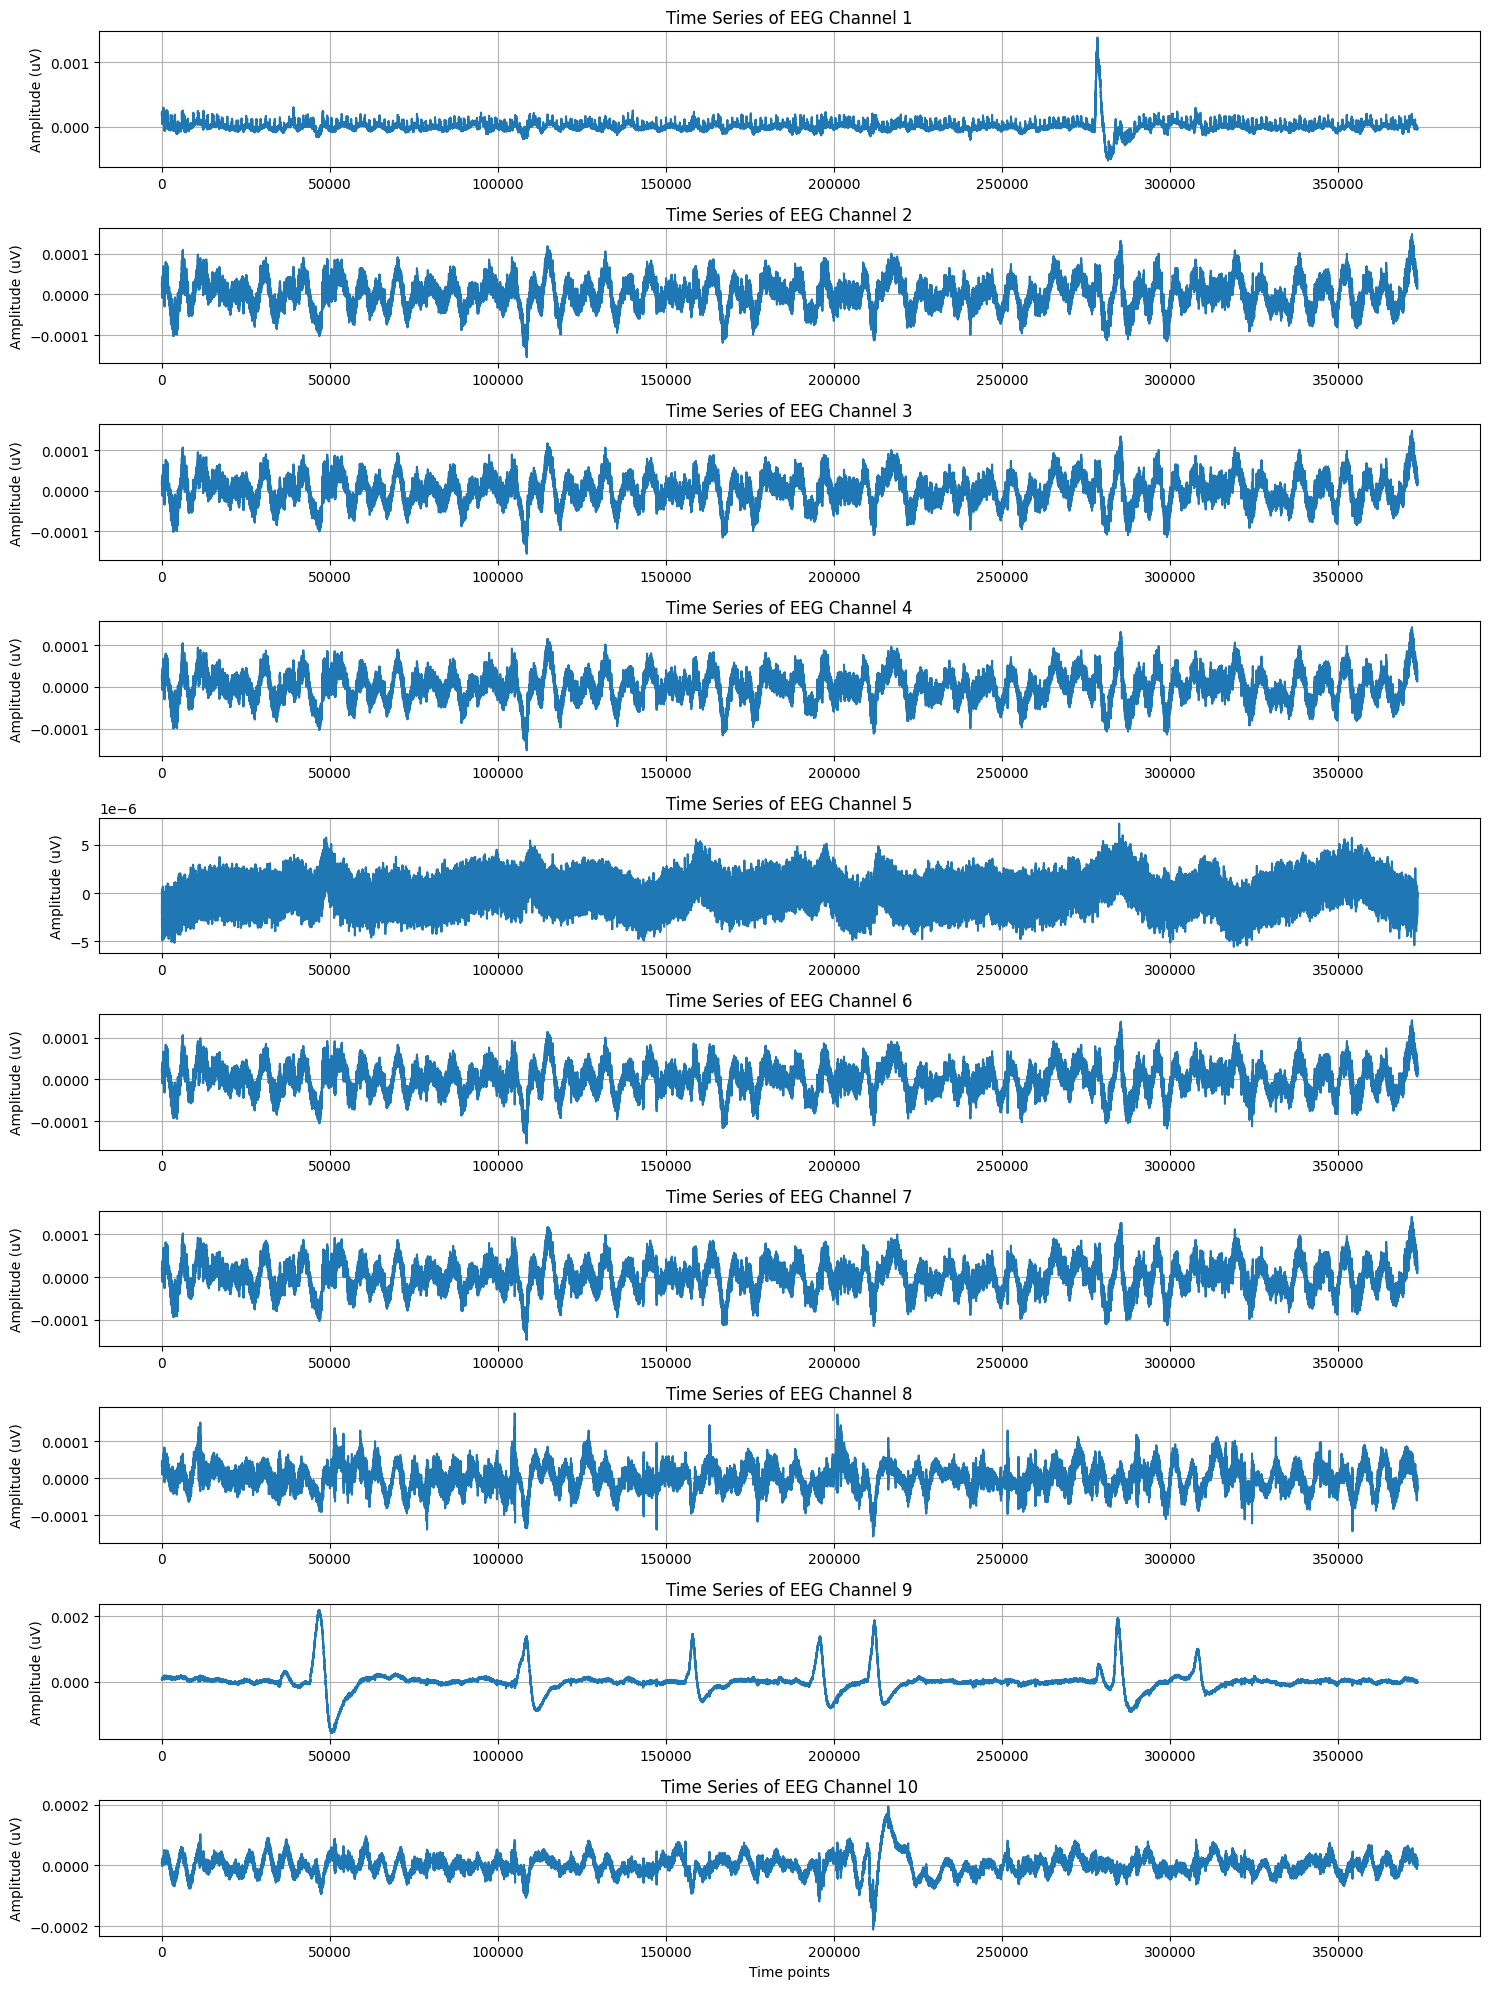

In [17]:
# Select the first subject from the batch
first_subject_data = imgs[0]

# Plot the time series for the first 10 channels
num_channels_to_plot = 10
plt.figure(figsize=(15, num_channels_to_plot * 2)) # Adjust figure size based on number of channels

for i in range(num_channels_to_plot):
    channel_data = first_subject_data[i, :]
    time_points = np.arange(len(channel_data))

    plt.subplot(num_channels_to_plot, 1, i + 1) # Create a subplot for each channel
    plt.plot(time_points, channel_data)
    plt.title(f'Time Series of EEG Channel {i+1}')
    plt.ylabel('Amplitude (uV)')
    if i == num_channels_to_plot - 1: # Only add xlabel to the last subplot
        plt.xlabel('Time points')
    plt.grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()